In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from keras.layers import concatenate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image

In [2]:
def inception_v4(x, num_filters):
    branch1 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(x)

    branch2 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(x)
    branch2 = layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(branch2)

    branch3 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(x)
    branch3 = layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(branch3)
    branch3 = layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(branch3)

    branch4 = layers.AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(num_filters, kernel_size=1, activation='relu')(branch4)

    x = layers.concatenate([branch1, branch2, branch3, branch4], axis=3)
    return x


inputs = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)

x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = inception_v4(x, 64)
x = inception_v4(x, 128)

x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = inception_v4(x, 256)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)

In [5]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
# Preprocess the data
train_images = train_images.reshape((60000, 28, 28, 1)) / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)) / 255.0

In [10]:
test_labels[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

In [9]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels), callbacks=[early_stop])

Epoch 1/10
469/469 [==============================] - 41s 50ms/step - loss: 0.7350 - accuracy: 0.7205 - val_loss: 0.4469 - val_accuracy: 0.8311
Epoch 2/10
469/469 [==============================] - 21s 46ms/step - loss: 0.3907 - accuracy: 0.8537 - val_loss: 0.3863 - val_accuracy: 0.8591
Epoch 3/10
469/469 [==============================] - 24s 50ms/step - loss: 0.3071 - accuracy: 0.8878 - val_loss: 0.2826 - val_accuracy: 0.8985
Epoch 4/10
469/469 [==============================] - 22s 46ms/step - loss: 0.2559 - accuracy: 0.9060 - val_loss: 0.2621 - val_accuracy: 0.9047
Epoch 5/10
469/469 [==============================] - 21s 46ms/step - loss: 0.2291 - accuracy: 0.9173 - val_loss: 0.2441 - val_accuracy: 0.9115
Epoch 6/10
469/469 [==============================] - 22s 47ms/step - loss: 0.2060 - accuracy: 0.9252 - val_loss: 0.2300 - val_accuracy: 0.9152
Epoch 7/10
469/469 [==============================] - 22s 47ms/step - loss: 0.1875 - accuracy: 0.9313 - val_loss: 0.2358 - val_accuracy:

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.2133 - accuracy: 0.9221
Test accuracy: 0.9221000075340271


In [12]:
model.save('/content/model/saved_model.h5')

In [13]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = train_images.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = train_images.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 16)           336         ['merge_features[1][0

In [14]:
train_groups = [train_images[np.where(train_labels==i)[0]] for i in np.unique(train_labels)]
test_groups = [test_images[np.where(test_labels==i)[0]] for i in np.unique(train_labels)]

In [15]:
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [16]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 82ms/step


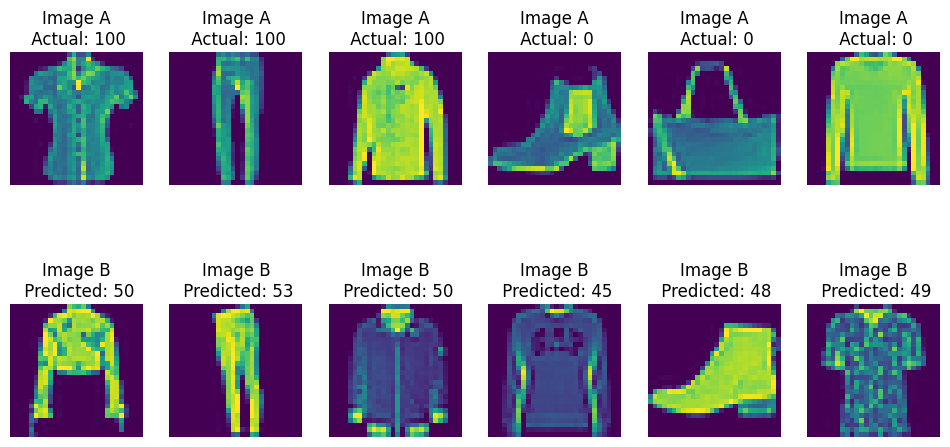

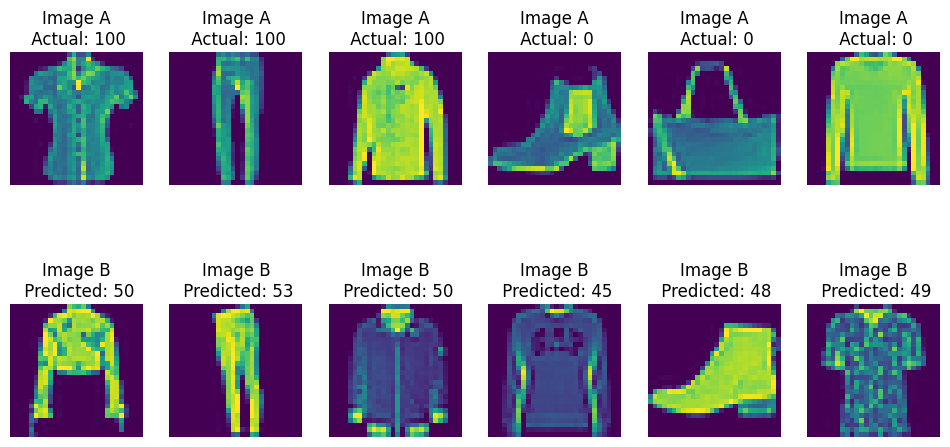

In [17]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
show_model_output()

In [18]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 50,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 2,
    verbose = True)

1/1 [==============================] - 0s 17ms/step
Epoch 1/2
50/50 [==============================] - 14s 233ms/step - loss: 0.6759 - mae: 0.4617 - val_loss: 0.6630 - val_mae: 0.4831
Epoch 2/2
50/50 [==============================] - 8s 158ms/step - loss: 0.5820 - mae: 0.4239 - val_loss: 0.6243 - val_mae: 0.4615


1/1 [==============================] - 0s 17ms/step


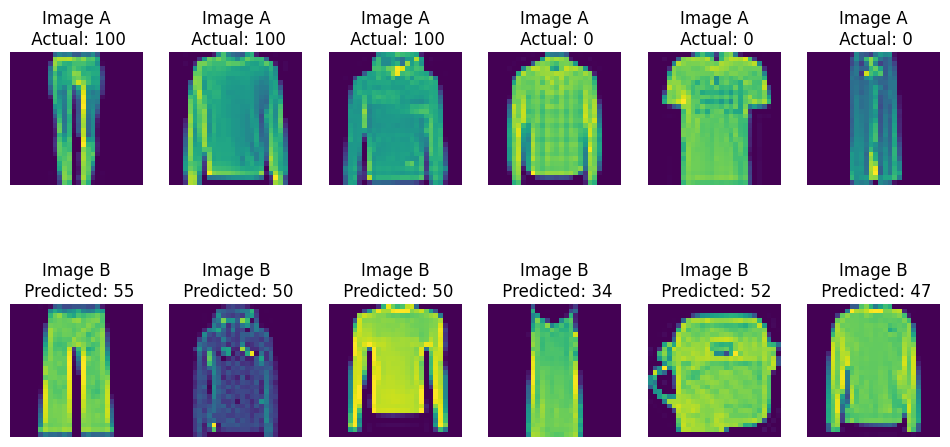

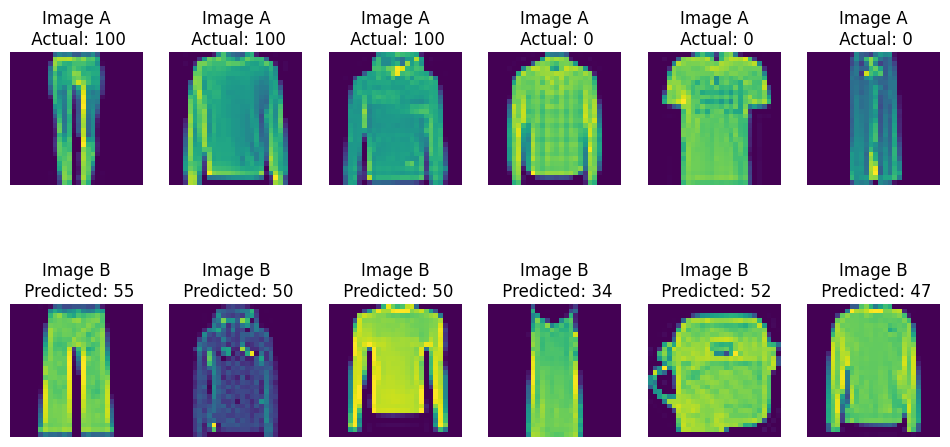

In [19]:
show_model_output()

In [20]:
%%time
x_test_features = model.predict(test_images, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 1s 13ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 0.531s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.268761
[t-SNE] KL divergence aft

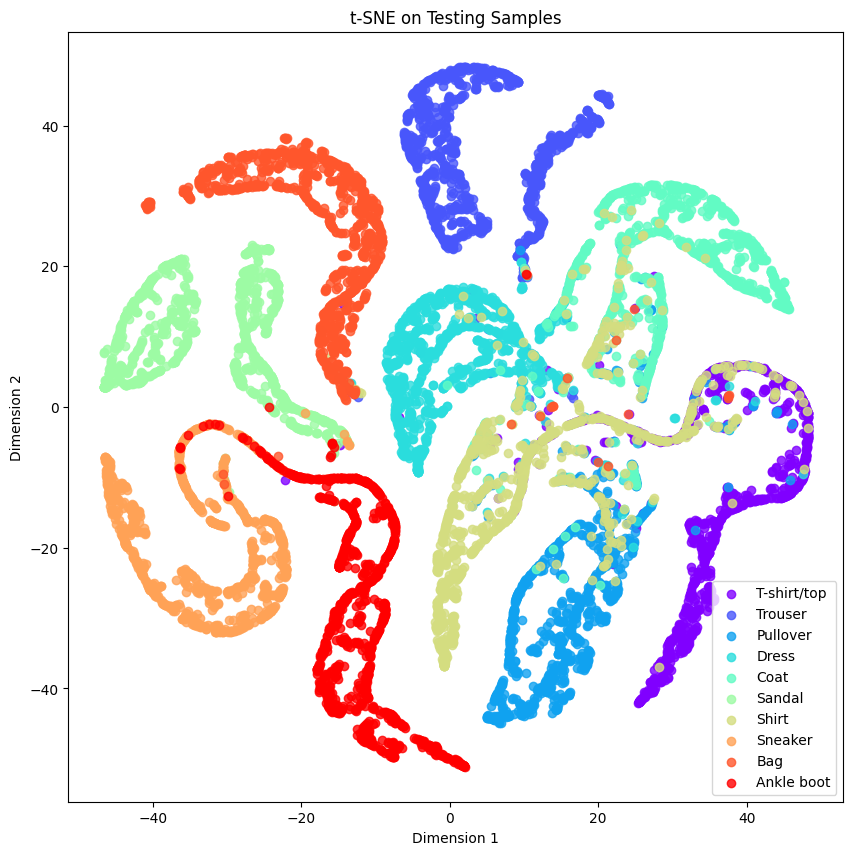

In [21]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_labels == c_group), 0],
        tsne_features[np.where(test_labels == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)